In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [127]:
import platform 

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

manifest_path = os.path.join(data_root,'allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json') 
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path) #creates a cache object
sessions = cache.get_session_table() #session_table is a pandas dataframe object that contains metadata about all sessions in the cache
sessions.head() #show the first 5 rows of the dataframe object 

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


In [149]:
session_id = 715093703 #import a session id of interest
session = cache.get_session_data(session_id) #creates a session object

presentations = session.get_stimulus_table('drifting_gratings') #creates a stimulus table object for drifting gratings
presentations = presentations[presentations.orientation != 'null'] #removes the null orientation presentations
region = "VISp" #specify the region of interest

#units = session.units[session.units["ecephys_structure_acronym"] == region] #creates a units table object for the region of interest

time_step = 0.01 #in sessions 
pre_stim_window = -0.1 #in seconds
window_duration = 0.5 #in seconds
time_bins = np.arange(pre_stim_window, window_duration + time_step, time_step) #create an array of time bins for the window of interest 

spikes = session.presentationwise_spike_counts(
    stimulus_presentation_ids = presentations.index.values, 
    bin_edges = time_bins, 
    unit_ids = session.units.query('snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 & ecephys_structure_acronym == @region').index.values
    )

In [157]:

#create the above into a fnction where the input is the session id and the output is the spike counts for the region of interest 
def get_spike_counts(session_id, region, window_duration):
    
    #to-do: 
        #update drifting_gratings can be changed to other stimuli 
    
    #input: session id, region of interest, window duration
        #session id: int, specific session id of interest
        #region of interest: string, specific region of interest
        #window duration: float, duration of the window of interest in seconds
        
    #output: spike counts for the region of interest in xarray format where the dimensions are unit, time, and stimulus presentation id in that order
    #example: spikes = get_spike_counts(715093703, "VISp", 0.5) 
    
    
    session = cache.get_session_data(session_id) #creates a session object  
    presentations = session.get_stimulus_table('drifting_gratings') #creates a stimulus table object for drifting gratings,  
    
    presentations = presentations[presentations.orientation != 'null'] #remove the null 
    time_step = 0.01 #in seconds 
    pre_stim_window = -0.1 #in seconds
    
    time_bins = np.arange(pre_stim_window, window_duration + time_step, time_step) #create an array of time bins for the window of interest 
    
    #apply the .presentationwise_spike_counts method to the session object to get the spike counts for the region of interest 
    spikes = session.presentationwise_spike_counts(
        stimulus_presentation_ids = presentations.index.values, 
        bin_edges = time_bins, 
        unit_ids = session.units.query('snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 & ecephys_structure_acronym == @region').index.values
        )
    return spikes


#test the function
spikes = get_spike_counts(715093703, "VISp", 0.5)

In [150]:
# grab distinct orientations (directions)
unique_orientations = presentations.orientation.unique()
unique_orientations.sort() 

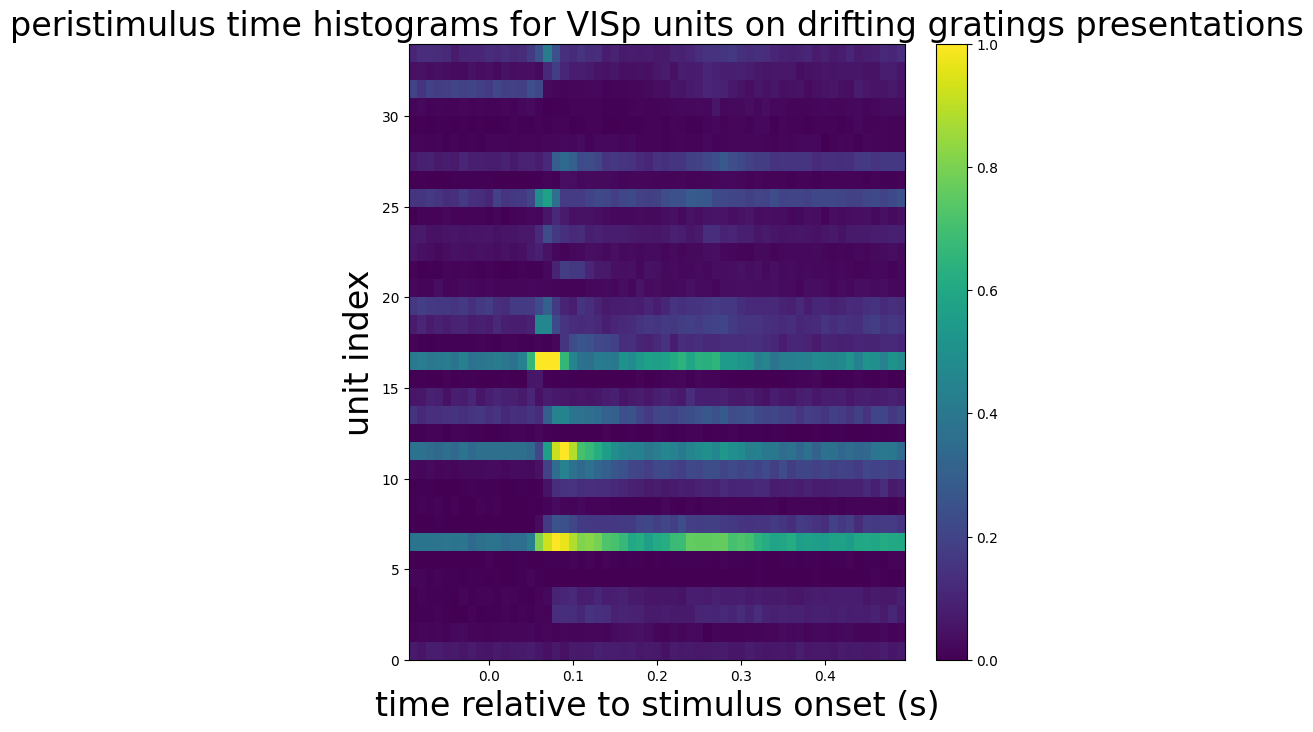

In [151]:
mean_spikes = spikes.mean(dim="stimulus_presentation_id")

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.pcolormesh(
    mean_spikes["time_relative_to_stimulus_onset"], # x axis 
    np.arange(mean_spikes["unit_id"].size), #arange for 
    mean_spikes.T, #transpose the matrix so that the units are on the y axis and time is on the x axis
    vmin=0,
    vmax=1
)
fig.colorbar(im, ax=ax)
ax.set_ylabel("unit index", fontsize=24)
ax.set_xlabel("time relative to stimulus onset (s)", fontsize=24)
ax.set_title("peristimulus time histograms for VISp units on drifting gratings presentations", fontsize=24)

plt.show()

In [153]:
unit_ids = session.units.query('snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 & ecephys_structure_acronym == @region').index.values
# conver the unit_ids to a list of values
unit_ids = unit_ids.tolist()

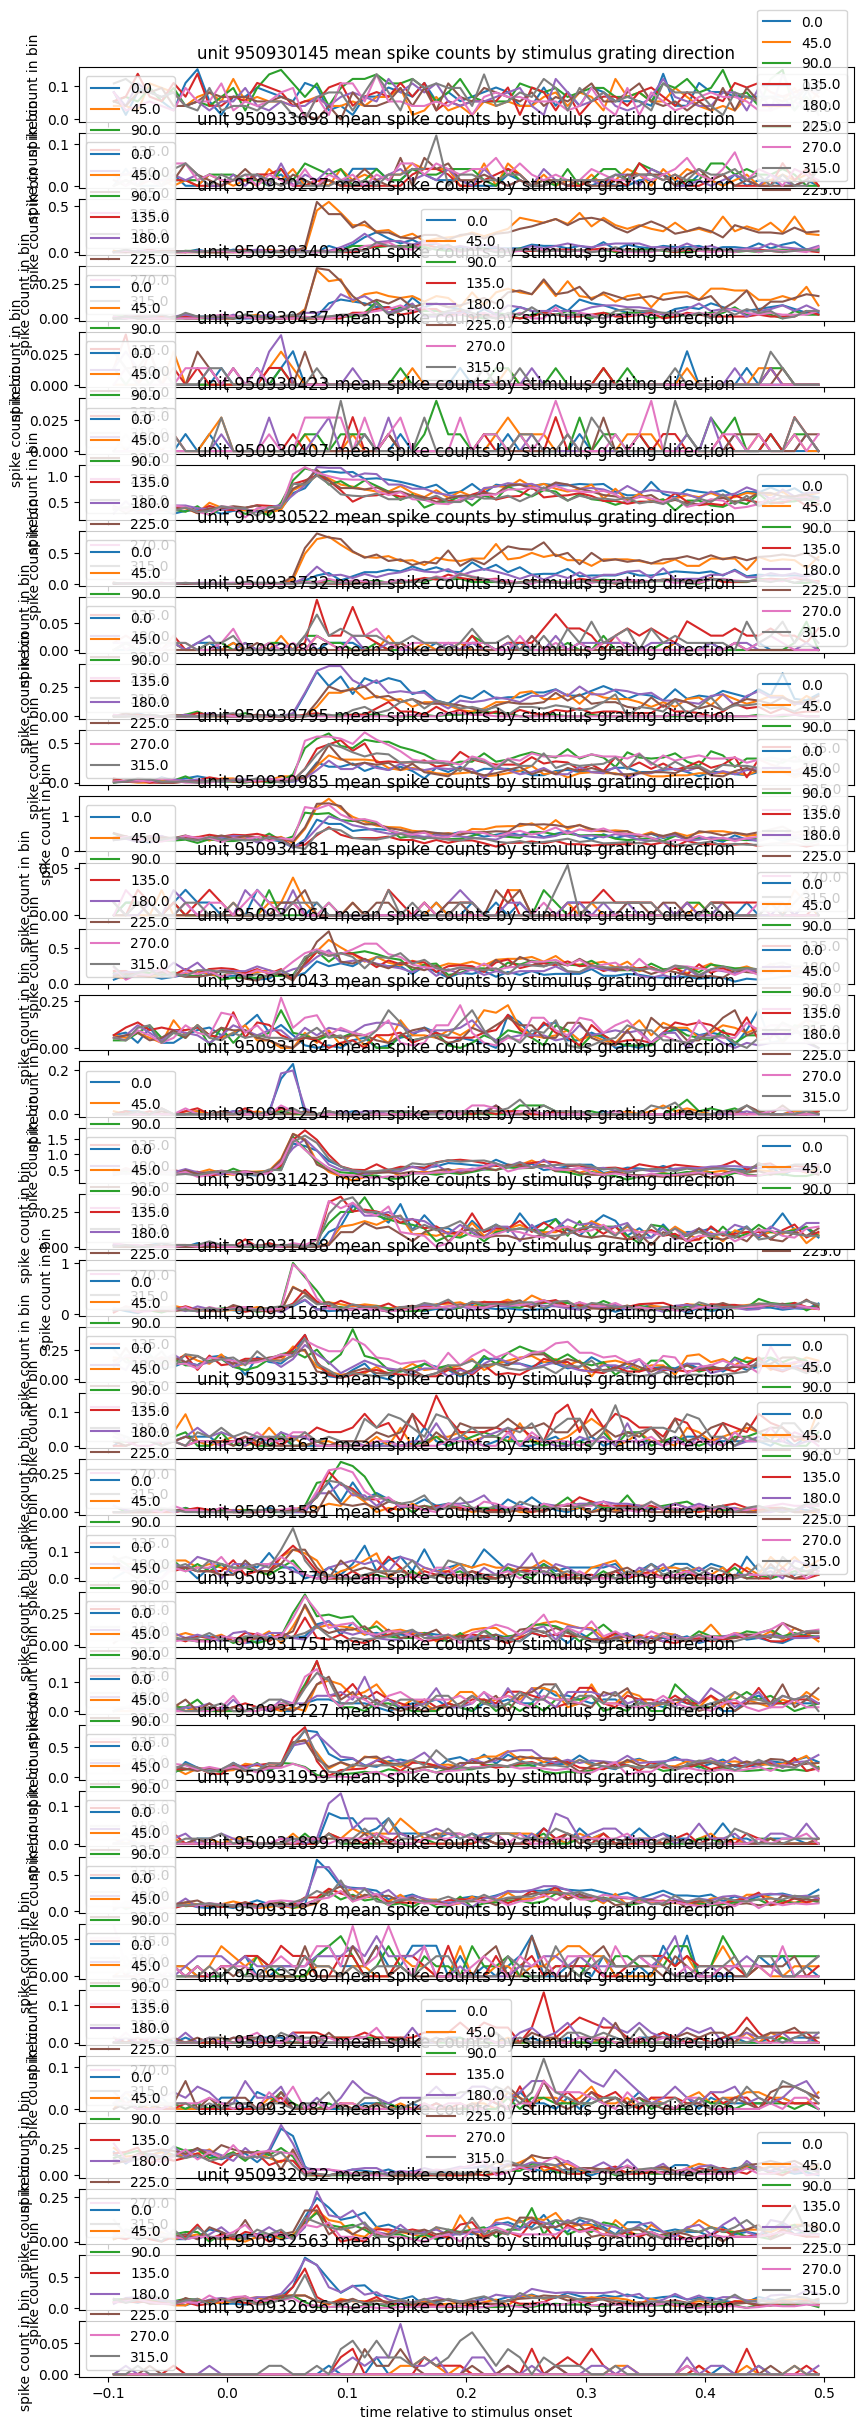

In [154]:
fig, ax = plt.subplots(len(unit_ids), 1, figsize=(10, 30))

for i, unit_id in enumerate(unit_ids):
    for orientation in unique_orientations: 
        trial_ids = presentations[presentations.orientation == orientation].index.values        
        data = spikes.loc[trial_ids, :, unit_id]
        mean = data.mean(dim="stimulus_presentation_id")
        ax[i].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
    ax[i].legend()
    ax[i].set_xlabel("time relative to stimulus onset")
    ax[i].set_ylabel("spike count in bin")
    ax[i].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")

In [52]:
all_areas = [] 

for index, row in sessions.iterrows(): 
    for a in row.ecephys_structure_acronyms: 
        if a not in all_areas: 
            all_areas.append(a)
            
print(all_areas)

['CA1', 'VISrl', nan, 'PO', 'LP', 'LGd', 'CA3', 'DG', 'VISl', 'PoT', 'VISp', 'grey', 'VISpm', 'APN', 'MB', 'VISam', 'TH', 'Eth', 'POL', 'NOT', 'SUB', 'VL', 'CA2', 'VPM', 'VISal', 'SCig', 'PPT', 'VIS', 'ProS', 'LGv', 'HPF', 'VISmma', 'PP', 'PIL', 'MGv', 'VPL', 'IGL', 'SGN', 'IntG', 'LD', 'MGm', 'MGd', 'POST', 'MRN', 'VISli', 'OP', 'ZI', 'VISmmp', 'PF', 'LT', 'RPF', 'PRE', 'SCiw', 'CP', 'RT', 'SCop', 'SCsg', 'SCzo']


In [53]:
#provide the number of unique specimens in the session table
print('Number of unique specimens in the session table: ' + str(len(sessions.specimen_id.unique())))
#count the number of unique full_genotype values in the session table
print('Number of unique full_genotype values in the session table: ' + str(len(sessions.full_genotype.unique())))
#provide the number of unique session_type values in the session table
print(cache.get_all_session_types())
#for each unique full_genotype value, count the number of sessions with that value
print('Number of sessions with each unique full_genotype value:')
print(sessions.full_genotype.value_counts())

Number of unique specimens in the session table: 58
Number of unique full_genotype values in the session table: 4
['brain_observatory_1.1', 'functional_connectivity']
Number of sessions with each unique full_genotype value:
wt/wt                                              30
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      12
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     8
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       8
Name: full_genotype, dtype: int64


In [49]:
# create a brain_observatory_type_sessions dataframe
brain_observatory_type_sessions = sessions[sessions["session_type"] == "brain_observatory_1.1"]

#for each unique full_genotype value, count the number of sessions with that value
print('Number of sessions with each unique full_genotype value:')
print(brain_observatory_type_sessions.full_genotype.value_counts())
/

Number of sessions with each unique full_genotype value:
wt/wt                                              16
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       6
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     5
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       5
Name: full_genotype, dtype: int64


In [125]:

presentations = session.get_stimulus_table('drifting_gratings') #creates a stimulus table object for drifting gratings
presentations = presentations[presentations.orientation != 'null'] #removes the null orientation presentations
region = 'VISp'#specify the region of interest
units = session.units[session.units["ecephys_structure_acronym"] == region] #creates a units table object for the region of interest


time_step = 0.05 #in sessions 
pre_stim_window = -0.1 #in seconds
window_duration = 0.5 #in seconds
time_bins = np.arange(pre_stim_window, window_duration + time_step, time_step) #create an array of time bins for the window of interest 

#session.units.query("snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9") #query the units table to find units that pass QC criteria which are stored as columns in the units table
# the QC criteria are: snr is greater than 2.5, isi_violations is less than 0.5, amplitude_cutoff is less than 0.1, and presence_ratio is greater than 0.9 

spikes = session.presentationwise_spike_counts(
    stimulus_presentation_ids = presentations.index.values, 
    bin_edges = time_bins, 
    unit_ids = session.units.query("snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 and ece ").index.values
    )


SyntaxError: Python keyword not valid identifier in numexpr query (<unknown>, line 1)

In [82]:
session.units

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
950910352,0.476196,106.785900,0.057700,6,419.57,4.576155,4.532385,0.029797,69.455405,0.002020,...,215.0,APN,8157,3521,6697,probeA,See electrode locations,29999.954846,1249.998119,True
950910364,0.953652,85.808775,0.065649,7,231.42,5.602703,31.486161,0.005998,102.847616,0.000146,...,215.0,APN,8154,3513,6698,probeA,See electrode locations,29999.954846,1249.998119,True
950910371,0.615593,76.898055,0.015509,8,209.31,5.061817,17.328610,0.005242,76.907610,0.004522,...,215.0,APN,8146,3487,6701,probeA,See electrode locations,29999.954846,1249.998119,True
950910392,0.616317,120.519555,0.025891,11,179.71,4.219074,16.262414,0.096884,65.671206,0.007306,...,215.0,APN,8133,3444,6707,probeA,See electrode locations,29999.954846,1249.998119,True
950910435,0.174735,66.974895,0.010061,17,99.99,6.393051,62.326305,0.004243,294.002222,0.000136,...,215.0,APN,8110,3367,6719,probeA,See electrode locations,29999.954846,1249.998119,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950956911,2.181048,91.264680,0.082007,205,166.36,1.917509,5.890958,0.270592,36.995342,0.132774,...,417.0,VISrl,7295,1020,8734,probeF,See electrode locations,30000.028033,1250.001168,True
950956870,0.496457,311.723490,0.000042,203,121.49,7.247881,0.647343,0.092982,80.682448,0.000068,...,417.0,VISrl,7295,1020,8734,probeF,See electrode locations,30000.028033,1250.001168,True
950956845,0.557797,137.348250,0.012523,201,235.47,4.235177,2.075303,0.262364,63.765826,0.001219,...,417.0,VISrl,7298,1031,8730,probeF,See electrode locations,30000.028033,1250.001168,True


In [68]:
session.structurewise_unit_counts #gives the number of units in each brain area for a given session

CA1      145
LP       139
grey     117
LGd       82
PO        76
VISrl     76
VISp      60
VISpm     50
VISl      42
VISam     30
APN       26
DG        26
CA3       14
PoT        1
Name: ecephys_structure_acronym, dtype: int64

In [ ]:

presentations = session.get_stimulus_table('drifting_gratings') #creates a stimulus table object for drifting gratings

presentations = presentations[presentations.orientation != 'null'] #removes the null orientation presentations

region = VISp' #specify the region of interest
time_step = 0.05 #in sessions 
pre_stim_window = -0.1 #in seconds
window_duration = 0.5 #in seconds
time_bins = np.arange(pre_stim_window, window_duration + time_step, time_step) #create an array of time bins for the window of interest 

#selects only VISp units 
units_good = session.units[session.units['ecephys_structure_acronym'] == region]

# use SDK to count spikes into bins 
spikes = session.presentationwise_spike_counts(
    stimulus_presentation_ids=presentations.index.values,
    bin_edges=time_bins, 
    unit_ids=units.index.values
)


In [10]:
#store the unique id values of the sessions in the brain_observatory_type_sessions dataframe in a list 
session_ids = brain_observatory_type_sessions.index.values.tolist()

#session_ids is a list of session ids in the brain_observatory_type_sessions dataframe

print('Number of sessions in the brain_observatory_type_sessions dataframe: ' + str(len(session_ids)))


Number of sessions in the brain_observatory_type_sessions dataframe: 32


In [39]:
#create a function that will take in session id and allow the user to access the meta data for that session 
def get_session_data(session_id):
    session_metadata = cache.get_session_data(session_id).metadata
    return session_metadata 

In [40]:
specific_id = session_1.get('ecephys_session_id') #use the get method to access the value associated with the key 'ecephys_session_id'

#print the value associated with the key 'ecephys_session_id'
print('ecephys_session_id for the first index of session_1: ' + str(session_1.get('ecephys_session_id')))

ecephys_session_id for the first index of session_1: 715093703


In [41]:
#using the specific session id, access the session data for that session 
session_1_data = cache.get_session_data(specific_id)

#how many units are there in the session table?
print('Number of units in the session table: ' + str(len(session_1_data.units)))

Number of units in the session table: 884


In [14]:
dg = session_1_data.get_stimulus_table('drifting_gratings')
dg[dg.orientation == 90]

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3799,0.8,90.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1577.777347,2.0,drifting_gratings,1579.779027,8.0,2.00168,247
3801,0.8,90.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1583.782367,2.0,drifting_gratings,1585.784047,2.0,2.00168,249
3807,0.8,90.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1601.797417,2.0,drifting_gratings,1603.799097,15.0,2.00168,254
3820,0.8,90.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1640.830033,2.0,drifting_gratings,1642.831703,8.0,2.00167,247
3823,0.8,90.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1649.837547,2.0,drifting_gratings,1651.839217,1.0,2.00167,263
...,...,...,...,...,...,...,...,...,...,...,...,...
49352,0.8,90.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,5144.790507,7.0,drifting_gratings,5146.792167,2.0,2.00166,249
49358,0.8,90.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,5162.805557,7.0,drifting_gratings,5164.807227,8.0,2.00167,247
49373,0.8,90.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,5207.843153,7.0,drifting_gratings,5209.844843,1.0,2.00169,263


In [45]:
#define regions of interest 
region_of_interest = ['VISp']; #visual cortex, primary, will be used for now and will be a list of strings 

#prepare the time bins for computing the PSTH 
time_step = 0.05 # in seconds, will be a user input later 
pre_time = -0.5 # in seconds, will be a user input later
time_bins = np.arange(pre_time, 1.5, time_step) #will be a user input later, pre_time is the start of the time bins, 1.5 is the end of the time bins, time_step is the step size between each time bin 

session_1_data.structurewise_unit_counts #this is a pandas dataframe object that contains the number of units in each brain area for the session

temporal_freqs = session_1_data.get_stimulus_table('drifting_gratings')['temporal_frequency'].unique()

In [48]:
session_1_data.unit?

Object `session_1_data.unit` not found.


In [25]:
presentations = session_1_data.get_stimulus_table(["drifting_gratings"]) #this is a pandas dataframe object that contains the stimulus table for drifting gratings
print(presentations['orientation'].unique()) #this prints the unique orientation values in the stimulus table for drifting gratings

presentations


def sort_orientation_and_temporal_freq(session_data): 
    #'sort_orientation_and_temporal_freq' will sort the stimulus table for drifting gratings by orientation and temporal frequency values
    
    #input: session_data, a session data object from the AllenSDK of a single session
    #output: a sorted stimulus table for drifting gratings
    
    #create a list of unique orientation values in the stimulus table
    presentations = session_data.get_stimulus_table('drifting_gratings')['orientation'].unique() 

    #create a list of unique temporal frequency values in the stimulus table
    temporal_freqs = session_data.get_stimulus_table('drifting_gratings')['temporal_frequency'].unique()
    
    #sort the dataframe for each unique combination of orientation and temporal frequency values
    for orientation in presentations: #iterate over each unique orientation value in the stimulus table
        for temporal_freq in temporal_freqs: #iterate over each unique temporal frequency value in the stimulus table 
            
            session.unit?
    

[315.0 90.0 225.0 135.0 0.0 270.0 'null' 180.0 45.0]


,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,315.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1574.774823,2.0,drifting_gratings,1576.776513,4.0,2.00169,246
3799,0.8,90.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1577.777347,2.0,drifting_gratings,1579.779027,8.0,2.00168,247
3800,0.8,225.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1580.779833,2.0,drifting_gratings,1582.781563,2.0,2.00173,248
3801,0.8,90.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1583.782367,2.0,drifting_gratings,1585.784047,2.0,2.00168,249
3802,0.8,135.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,1586.784883,2.0,drifting_gratings,1588.786553,8.0,2.00167,250
...,...,...,...,...,...,...,...,...,...,...,...,...
49426,0.8,135.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,5366.976107,7.0,drifting_gratings,5368.977777,15.0,2.00167,274
49427,0.8,180.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,5369.978603,7.0,drifting_gratings,5371.980283,8.0,2.00168,260
49428,0.8,0.0,"[21211.93333333, 21211.93333333]","[250.0, 250.0]",0.04,5372.981107,7.0,drifting_gratings,5374.982807,1.0,2.00170,251


884 units total
131 units have snr > 4


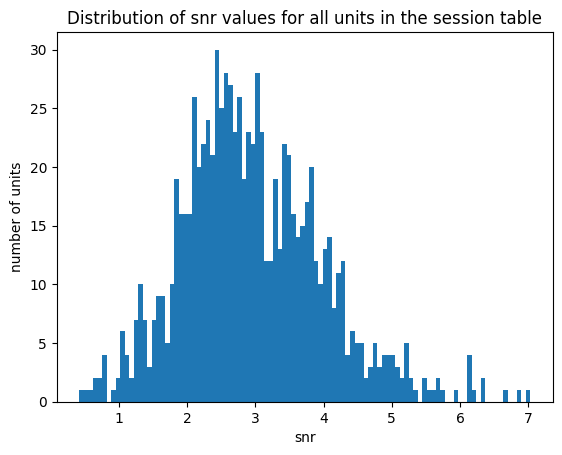

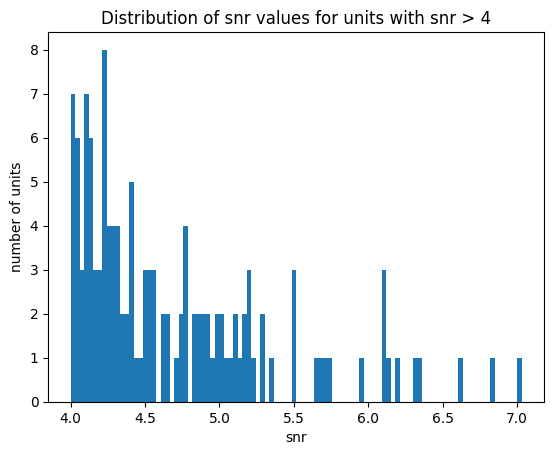

KstestResult(statistic=0.9999683747306906, pvalue=0.0, statistic_location=4.00034374998353, statistic_sign=-1)

In [47]:
print(f'{session_1_data.units.shape[0]} units total') #print the number of units in the session table
units_with_very_high_snr = session_1_data.units[session_1_data.units['snr'] > 4] #create a dataframe of units with snr > 4
print(f'{units_with_very_high_snr.shape[0]} units have snr > 4') #print the number of units with snr > 4

#plot the distribution of snr values for all units in the session table 
plt.hist(session_1_data.units['snr'], bins=100)
plt.xlabel('snr')
plt.ylabel('number of units')
plt.title('Distribution of snr values for all units in the session table')
plt.show()

#test for bimodality of snr values in the session table
from scipy.stats import kstest
kstest(session_1_data.units['snr'], 'norm') #if the p-value is less than 0.05, then the distribution is not normal

#plot the distribution of snr values for units with snr > 4
plt.hist(units_with_very_high_snr['snr'], bins=100)
plt.xlabel('snr')
plt.ylabel('number of units')
plt.title('Distribution of snr values for units with snr > 4')
plt.show()

#test for bimodality of snr values for units with snr > 4 
kstest(units_with_very_high_snr['snr'], 'norm') #if the p-value is less than 0.05, then the distribution is not normal



/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_24116/3479032595.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  snr_values = snr_values.append(session_units) #append the session_units dataframe to the snr_values dataframe
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_24116/3479032595.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  snr_values = snr_values.append(session_units) #append the session_units dataframe to the snr_values dataframe
/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_24116/3479032595.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  snr_values = snr_values.append(session_units) #append the session_units dataframe to the snr_values dataframe
/var/folders/ws/

(array([  3.,  10.,  20.,  25.,  48.,  59., 110., 112., 157., 173., 204.,
        264., 308., 400., 445., 493., 568., 688., 733., 802., 803., 871.,
        868., 883., 896., 937., 894., 842., 779., 695., 618., 596., 571.,
        546., 465., 459., 424., 368., 347., 361., 324., 247., 276., 229.,
        204., 182., 158., 147., 128., 126., 107., 114.,  83.,  70.,  68.,
         63.,  48.,  44.,  56.,  33.,  31.,  29.,  24.,  20.,  36.,  17.,
         17.,  18.,  14.,  13.,   8.,   7.,   7.,  11.,   5.,   5.,   2.,
          0.,   4.,   1.,   3.,   1.,   1.,   2.,   3.,   1.,   1.,   2.,
          1.,   0.,   2.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([0.07869794, 0.17709049, 0.27548304, 0.37387559, 0.47226814,
        0.57066068, 0.66905323, 0.76744578, 0.86583833, 0.96423088,
        1.06262343, 1.16101598, 1.25940852, 1.35780107, 1.45619362,
        1.55458617, 1.65297872, 1.75137127, 1.84976382, 1.94815636,
        2.04654891, 2.14494146, 2.24333401, 2.

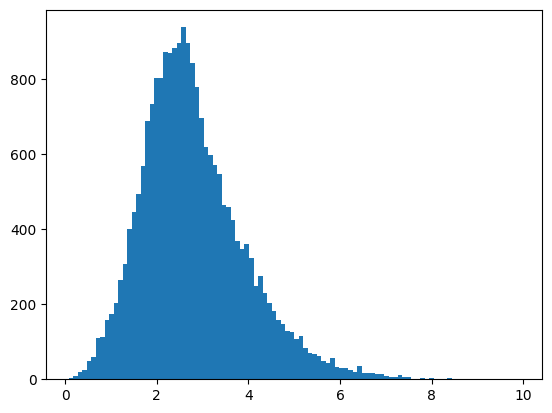

In [48]:
#create a function that will iterate over the session_ids list, access the session data for each session id, and store the snr values for each session 
# pandas dataframe 

def get_snr_values(session_ids):
    snr_values = pd.DataFrame(columns=['session_id', 'unit_id', 'snr']) #create an empty pandas dataframe with columns 'session_id', 'unit_id', and 'snr'
    
    for session_id in session_ids: #iterate over the session_ids list
        session_data = cache.get_session_data(session_id) #access the session data for each session id
        session_units = session_data.units[['snr']] #create a dataframe with the snr values for each unit in the session
        session_units['unit_id'] = session_units.index #add a column 'unit_id' with the index values of the session_units dataframe
        session_units['session_id'] = session_id #add a column 'session_id' with the current session_id value
        session_units = session_units[['session_id', 'unit_id', 'snr']] #reorder the columns of the session_units dataframe
        snr_values = snr_values.append(session_units) #append the session_units dataframe to the snr_values dataframe
    return snr_values

#use the function to create a dataframe with the snr values for each unit in the session table
snr_values = get_snr_values(session_ids)

#plot the distribution of snr values for all units in the session table
plt.hist(snr_values['snr'], bins=100) #took 39m to run 

In [49]:
#save the snr_values dataframe as a csv file to the current working directory
snr_values.to_csv('snr_values_allunits.csv', index=False) 

In [51]:
# We're going to build an array of spike counts surrounding stimulus presentation onset
# To do that, we will need to specify some bins (in seconds, relative to stimulus onset)
time_bin_edges = np.linspace(-0.01, 0.4, 200)

# do the the above but for the sessin_1 data
flash_250_ms_stimulus_presentation_ids = session_1_data.stimulus_presentations[
    session_1_data.stimulus_presentations['stimulus_name'] == 'flashes'
].index.values

# and get a set of units with only decent snr
decent_snr_unit_ids = session_1_data.units[
    session_1_data.units['snr'] >= 1.5
].index.values

spike_counts_da = session_1_data.presentationwise_spike_counts(
    bin_edges=time_bin_edges,
    stimulus_presentation_ids=flash_250_ms_stimulus_presentation_ids,
    unit_ids=decent_snr_unit_ids
)

spike_counts_da 

#determine the number of unique units in the spike_counts_da dataframe
print('Number of unique units in the spike_counts_da dataframe: ' + str(len(spike_counts_da.unit_id.unique())))


<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 150,
                                  time_relative_to_stimulus_onset: 199,
                                  unit_id: 828)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3647 .....
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 ...
  * unit_id                          (unit_id) int64 950910352 ... 950957053

In [52]:
mean_spike_counts = spike_counts_da.mean(dim='stimulus_presentation_id')
mean_spike_counts

<xarray.DataArray 'spike_counts' (time_relative_to_stimulus_onset: 199,
                                  unit_id: 828)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01333333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00666667,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00666667, 0.00666667,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00666667,
        0.        ]])
Coordinates:
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 ...
  * unit_id                          (unit_id) int64 950910352 ... 950957053

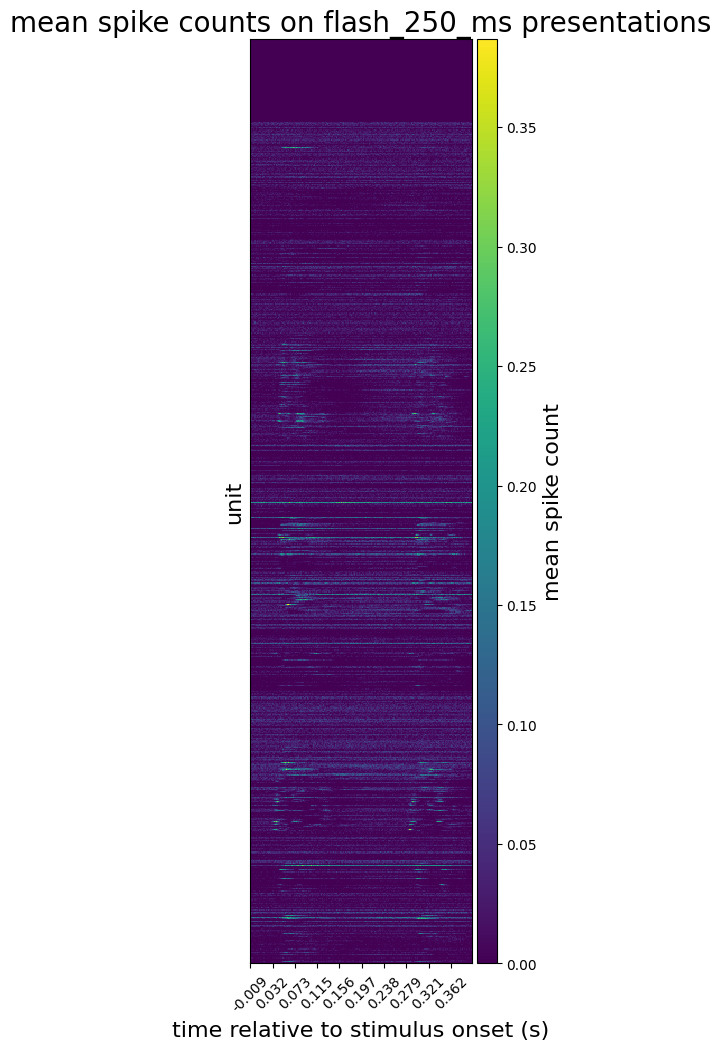

In [68]:
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot

plot_spike_counts(
    mean_spike_counts,
    mean_spike_counts['time_relative_to_stimulus_onset'],
    'mean spike count',
    'mean spike counts on flash_250_ms presentations'
)
plt.show() 

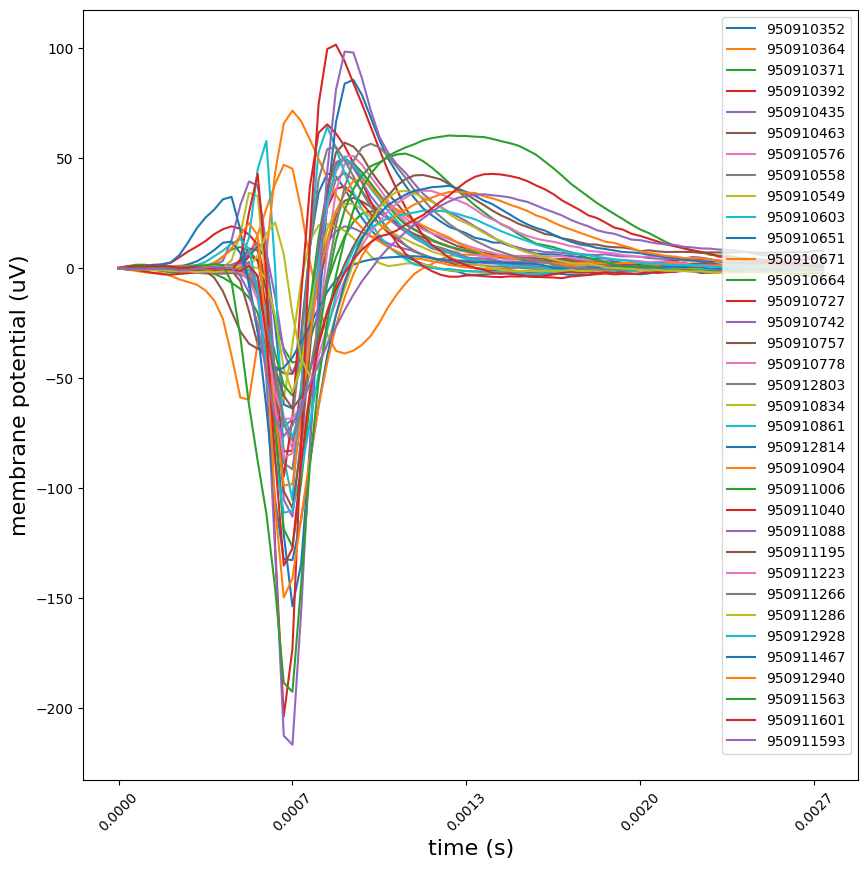

In [55]:
# use the session_1 data
units_of_interest = decent_snr_unit_ids[:35] #take the first 35 units with decent snr values

waveforms = {uid: session_1_data.mean_waveforms[uid] for uid in units_of_interest} #create a dictionary with the mean waveform for each unit of interest 
peak_channels = {uid: session_1_data.units.loc[uid, 'peak_channel_id'] for uid in units_of_interest} #create a dictionary with the peak channel for each unit of interest

# plot the mean waveform on each unit's peak channel for each unit of interest
plot_mean_waveforms(waveforms, units_of_interest, peak_channels) 
plt.show()


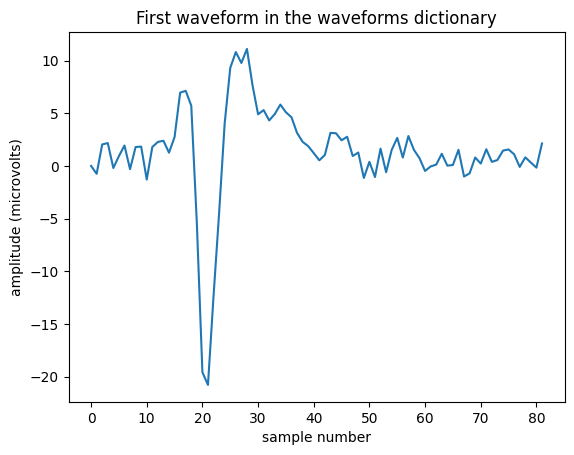

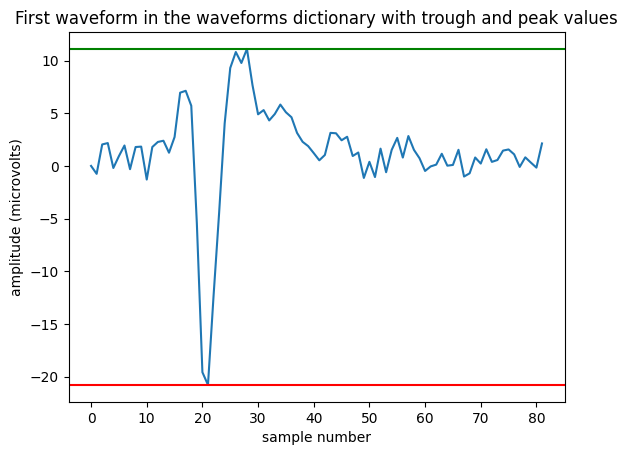

In [57]:
#plot the first waveform in the waveforms dictionary to visualize how the trough to peak amplitude is calculated 
plt.plot(waveforms[units_of_interest[0]].values[0])
plt.xlabel('sample number')
plt.ylabel('amplitude (microvolts)')
plt.title('First waveform in the waveforms dictionary')
plt.show()

#now overlay what the trough and peak values are on the first waveform in the waveforms dictionary
plt.plot(waveforms[units_of_interest[0]].values[0])
plt.axhline(y=waveforms[units_of_interest[0]].values[0].min(), color='r', linestyle='-')
plt.axhline(y=waveforms[units_of_interest[0]].values[0].max(), color='g', linestyle='-')
plt.xlabel('sample number')
plt.ylabel('amplitude (microvolts)')
plt.title('First waveform in the waveforms dictionary with trough and peak values')
plt.show()



In [ ]:
#lets develop a function that will allow me to perform calculations on the waveforms dictionary 
def get_waveform_values(waveforms, units_of_interest):
        #create an empty pandas dataframe with columns 'unit_id', 'trough_to_peak_amplitude', 'trough_to_peak_time', 'trough_time', 'peak_time', 'trough_amplitude', and 'peak_amplitude'
        waveform_values = pd.DataFrame(columns=['unit_id', 'trough_to_peak_amplitude', 'trough_to_peak_time', 'trough_time', 'peak_time', 'trough_amplitude', 'peak_amplitude'])
        
        for unit_id in units_of_interest: #iterate over the units_of_interest list
            #normalize the wave form for each unit in the waveforms dictionary based on absolute min value
            normalized_waveform = waveforms[unit_id].values[0] - waveforms[unit_id].values[0].min()
            
            #plot the normalized waveform for each unit in the waveforms dictionary
            

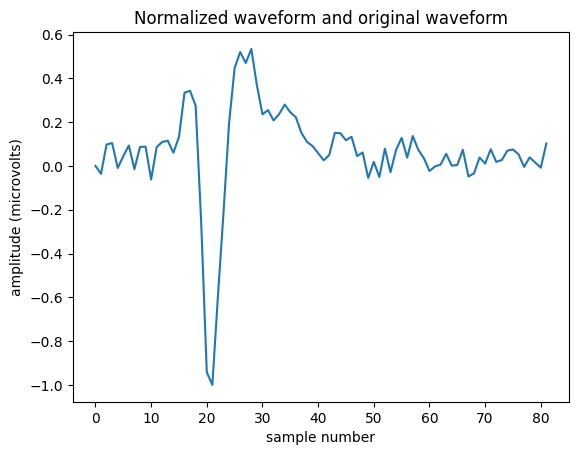

In [61]:
#grab the first waveform in the waveforms dictionary to test the function
waveform = waveforms[units_of_interest[0]].values[0]

#find the max absolute in the waveform and then divide the waveform by that value
normalized_waveform = waveform / np.max(np.abs(waveform)) #normalize the waveform based on absolute max value 

#plot the normalized waveform and the original waveform

plt.plot(normalized_waveform)
plt.xlabel('sample number')
plt.ylabel('amplitude (microvolts)')
plt.title('Normalized waveform and original waveform')
plt.show()




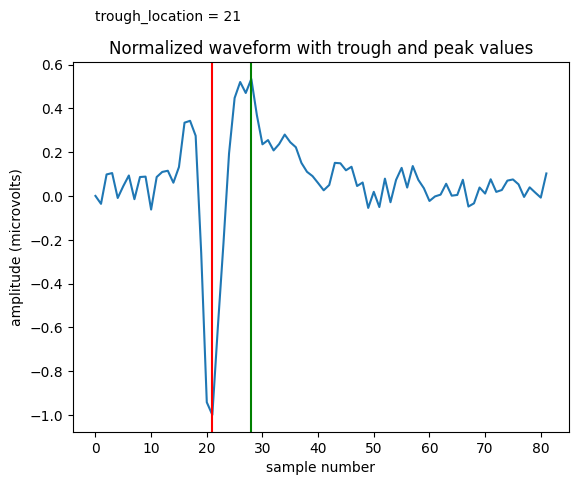

In [66]:
#grab the first waveform in the waveforms dictionary to test the function
waveform = waveforms[units_of_interest[0]].values[0]

#find the max absolute in the waveform and then divide the waveform by that value
normalized_waveform = waveform / np.max(np.abs(waveform)) #normalize the waveform based on absolute max value 

# Normalizing
trough_location = np.where(normalized_waveform == np.min(normalized_waveform))[0][0]
max_after_trough = np.max(normalized_waveform[trough_location:])
max_after_trough_location = np.where(normalized_waveform == max_after_trough)[0][0]
max_before_trough = np.max(normalized_waveform[:trough_location])
max_before_trough_location = np.where(normalized_waveform == max_before_trough)[0][0]
difference = (max_after_trough_location - trough_location)/30 # ms trough to peak

#based on the normalize waveform, plot each of the values that will be calculated in the function on the waveform
plt.plot(normalized_waveform)
#add the name of the variable and the value of the variable to the plot
plt.text(0, 0.8, 'trough_location = ' + str(trough_location))

plt.axvline(x=trough_location, color='r', linestyle='-')
plt.axvline(x=max_after_trough_location, color='g', linestyle='-')

plt.xlabel('sample number')
plt.ylabel('amplitude (microvolts)')
plt.title('Normalized waveform with trough and peak values')
plt.show()

    

In [70]:
#the levels of the dictionary are: session_id, unit_id and within unit_id, there are the following keys: 'trough_to_peak_amplitude', 'trough_to_peak_time', 'trough_time', 'peak_time', 'trough_amplitude', and 'peak_amplitude' 'raw_waveform', 
# 'normalized_waveform', 'cell_type' 

#create the dictinoary where the first level are the unqiue session ids where the key is the session id and the value is a dictionary where the key is the unique unit id and the value is a dictionary 
# where where the keys are 'trough_to_peak_amplitude', 'trough_to_peak_time', 'trough_time', 'peak_time', 'trough_amplitude', and 'peak_amplitude' 'raw_waveform', 
# 'normalized_waveform', 'cell_type' 

waveform_values = {session_id: {unit_id: {'trough_to_peak_amplitude': None, 'trough_to_peak_time': None, 'trough_time': None, 'peak_time': None, 'trough_amplitude': None, 'peak_amplitude': None, 'raw_waveform': None, 'normalized_waveform': None, 'cell_type': None} for unit_id in units_of_interest} for session_id in session_ids}
         

In [74]:
#what are the unique number of session ids in the waveform_values dictionary?
print('Number of unique session ids in the waveform_values dictionary: ' + str(len(waveform_values.keys())))


Number of unique session ids in the waveform_values dictionary: 32


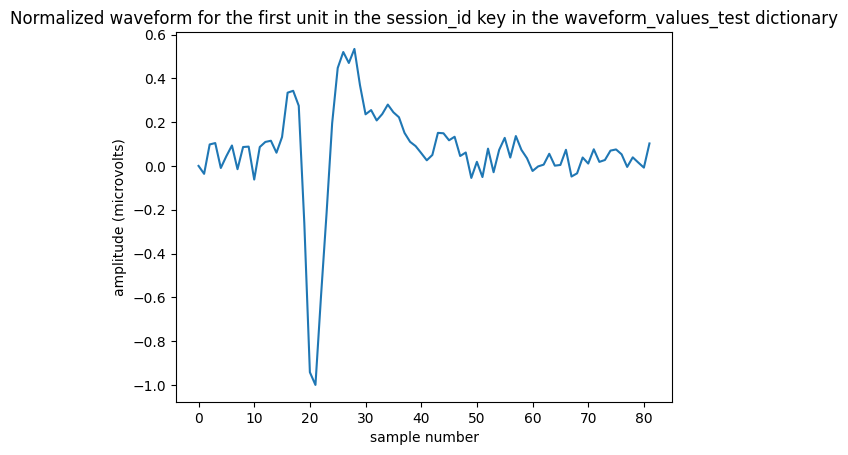

Number of keys in the first entry of the session_id key in the waveform_values_test dictionary: 9


In [94]:
#grab the first waveform in the waveforms dictionary to test the function
waveform = waveforms[units_of_interest[0]].values[0]

#find the max absolute in the waveform and then divide the waveform by that value
normalized_waveform = waveform / np.max(np.abs(waveform)) #normalize the waveform based on absolute max value 

# Normalizing
trough_location = np.where(normalized_waveform == np.min(normalized_waveform))[0][0]
max_after_trough = np.max(normalized_waveform[trough_location:])
max_after_trough_location = np.where(normalized_waveform == max_after_trough)[0][0]
max_before_trough = np.max(normalized_waveform[:trough_location])
max_before_trough_location = np.where(normalized_waveform == max_before_trough)[0][0]
difference = (max_after_trough_location - trough_location)/30 # ms trough to peak

#create a function to iterative enter the dictionary waveforms_values with the values for each unit of interest and use this key to access session_1_data.units 
def get_waveform_from_all_sessions(input_dict):
    #iterate over the keys in the input_dict
    for session_id in input_dict.keys():
        #iterate over the the cell ids in the input_dict
        for unit_id in input_dict[session_id].keys(): 
            
            #store the mean waveform within in 'raw_waveform' key 
            input_dict[session_id][unit_id]['raw_waveform'] = session_1_data.mean_waveforms[unit_id].values[0]
            
            #find the max absolute in the waveform and then divide the waveform by that value
            normalized_waveform = input_dict[session_id][unit_id]['raw_waveform'] / np.max(np.abs(input_dict[session_id][unit_id]['raw_waveform'])) #normalize the waveform based on absolute max value
            
            #store the normalized waveform within the 'normalized_waveform' key
            input_dict[session_id][unit_id]['normalized_waveform'] = normalized_waveform
            
            #perform calculations on the normalized waveform to find the trough_to_peak_amplitude, trough_to_peak_time, trough_time, peak_time, trough_amplitude, and peak_amplitude
            trough_location = np.where(normalized_waveform == np.min(normalized_waveform))[0][0]
            max_after_trough = np.max(normalized_waveform[trough_location:])
            max_after_trough_location = np.where(normalized_waveform == max_after_trough)[0][0]
            max_before_trough = np.max(normalized_waveform[:trough_location])
            max_before_trough_location = np.where(normalized_waveform == max_before_trough)[0][0]
            difference = (max_after_trough_location - trough_location)/30 # ms trough to peak
            
            #store the trough_to_peak_amplitude, trough_to_peak_time, trough_time, peak_time, trough_amplitude, and peak_amplitude values within the input_dict
            input_dict[session_id][unit_id]['trough_to_peak_amplitude'] = difference
            input_dict[session_id][unit_id]['trough_to_peak_time'] = difference
            input_dict[session_id][unit_id]['trough_time'] = trough_location
            input_dict[session_id][unit_id]['peak_time'] = max_after_trough_location
            input_dict[session_id][unit_id]['trough_amplitude'] = max_before_trough
            input_dict[session_id][unit_id]['peak_amplitude'] = max_after_trough
            
            #classify the cell type based on difference value 
            if difference < 0.4:
                input_dict[session_id][unit_id]['cell_type'] = 'FS'
            elif difference > 0.4:
                input_dict[session_id][unit_id]['cell_type'] = 'RS'
            
    return input_dict

#pull out the first session id in the waveform_values dictionary to test the function
session_id = list(waveform_values.keys())[0]

#use this session id to test the function 
waveform_values_test = get_waveform_from_all_sessions({session_id: waveform_values[session_id]})

#access the content of the session_id key in the waveform_values_test dictionary
waveform_values_test[session_id]

#plot the normalized waveform for the first unit in the session_id key in the waveform_values_test dictionary
plt.plot(waveform_values_test[session_id][units_of_interest[0]]['normalized_waveform'])
plt.xlabel('sample number')
plt.ylabel('amplitude (microvolts)')
plt.title('Normalized waveform for the first unit in the session_id key in the waveform_values_test dictionary')
plt.show()

#what are the number of keys in the first entry of the session_id key in the waveform_values_test dictionary?
print('Number of keys in the first entry of the session_id key in the waveform_values_test dictionary: ' + str(len(waveform_values_test[session_id][units_of_interest[0]].keys())))            
            
            
            
            

In [ ]:
#proceed to use the function 